In [1]:
#pip install ucimlrepo

In [2]:
# VARI IMPORT
import pandas as pd
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import numpy as np
import openpyxl
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import entropy

## Importiamo il DataSet

In [3]:
# fetch dataset 
website_phishing = fetch_ucirepo(id=379) 

data = website_phishing.data.features 
target = website_phishing.data.targets


# variable information 
print(website_phishing.variables) 
features = data.columns

# Get the number of rows and columns
n_rows, n_columns = data.shape

print(f"\nNumero di righe: {n_rows}")
print(f"Numero di colonne: {n_columns}")

                name     role     type demographic description units  \
0                SFH  Feature  Integer        None        None  None   
1        popUpWindow  Feature  Integer        None        None  None   
2     SSLfinal_State  Feature  Integer        None        None  None   
3        Request_URL  Feature  Integer        None        None  None   
4      URL_of_Anchor  Feature  Integer        None        None  None   
5        web_traffic  Feature  Integer        None        None  None   
6         URL_Length  Feature  Integer        None        None  None   
7      age_of_domain  Feature  Integer        None        None  None   
8  having_IP_Address  Feature  Integer        None        None  None   
9             Result   Target  Integer        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7             no  
8             no  
9             no 

## Istogramma delle Feature

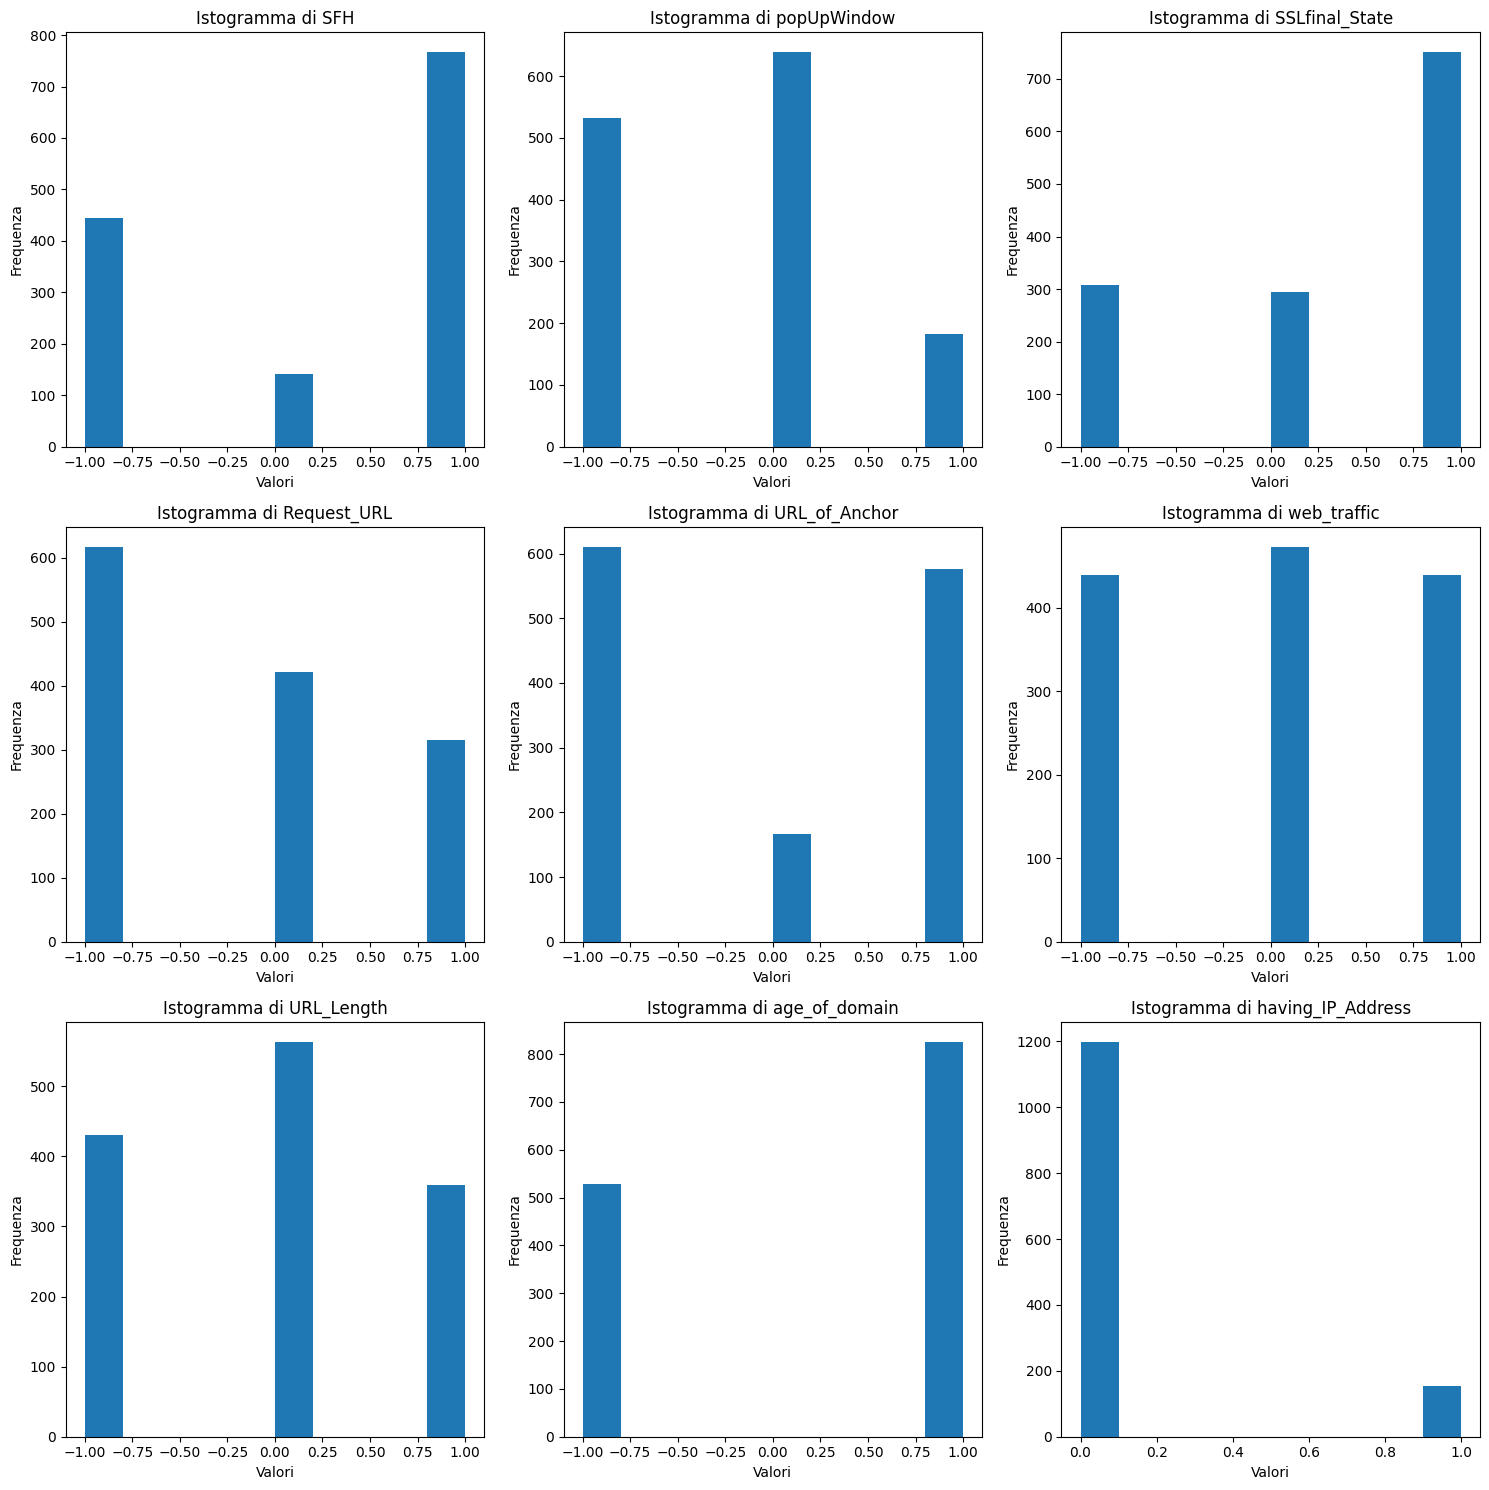

In [4]:
# Imposta il layout dei subplot
fig, axs = plt.subplots(3, 3, figsize=(15, 15)) # Adatta la dimensione come necessario

# Crea un istogramma per ogni feature
for i, ax in enumerate(axs.flatten()):
    ax.hist(data[features[i]])
    ax.set_title(f'Istogramma di {features[i]}')
    ax.set_xlabel('Valori')
    ax.set_ylabel('Frequenza')

# Mostra il grafico
plt.tight_layout()
plt.show()

In questa sezione di codice mostriamo l'istogramma delle feature. Possiamo notare le seguenti caratteristiche:

<ol>
    <li> Nella feature <b>having_ip_address</b> c'è una maggioranza dei dati 0 rispetto ai dati 1 e -1. Questa feature può aiutarci nel riconoscere un sito sospetto. </li>
    <li> Nella feature <b>web_traffic</b> c'è un bilanciamento dei dati 0, -1, 1. Questa feature non ci da molte informazioni riguardante il riconoscimento di siti phishing e siti non phishing e suspicious.</li>
    <li> Nella feature <b>age_of_domain</b> non sono presenti degli 0, quindi può darci una mano nel riconoscimento di siti phishing oppure non phishing.</li>
    <li> Nella feature <b>Url_of_anchor</b> è presente una maggioranza di 1 e -1 (anche in questo caso più o meno bilanciati) rispetto agli 0, quindi può darci una mano nel riconoscimento di siti phishing oppure non phishing.</li>
    <li> Nella feature <b>SFH</b> è presente una maggioranza di 1 rispetto agli altri valori, quindi può darci una mano nel riconoscimento di siti phishing oppure non phishing.</li>

</ol>

### Riconoscere sito Phishing, no Phishing, Suspicious

<ol>
    <li> <b>having_ip_address</b> Se un sito ha l'ip address nell'url, allora è phishing. </li>
    <li> <b>long_url</b> Se l'url del sito è composto da almeno 75 caratteri è phishing, se è compreso tra 54 e 74 caratteri è suspicious, altrimenti è legit.</li>
    <li> <b>url_of_anchor</b> se i link all'interno della pagina puntano a un dominio esterno, potrebbe essere phishing.</li>
    <li> <b>Request_Url</b> Se gli oggetti sono stati caricati da un altro dominio oltre quello che compare nella barra Url, allora il sito potrebbe essere phishing.</li>
    <li> <b>SFH</b> Se le informazioni vengono inviate ad un server diverso da quello del dominio allora il sito è phishing.</li>
    <li> <b>website_traffic</b> Se il sito presenta un basso traffico, potrebbe essere phishing.</li>
    <li> <b>age_of_domain</b> Se il sito è stato creato di recente, allora potrebbe essere phishing.</li>
 <li> <b>pop_up_window</b> Se il sito mostra un pop-up dove venogono chieste le informazioni personali, allora potrebbe essere phishing.</li>
 <li> <b>Ssl_final_state</b> Se utilizzano un protocollo HTTPS fasullo, allora il sito è phishing.</li>

</ol>


## Preprocessing dei dati
### Collinearità e Multicollinearità delle variabili

A parte una correlazione negativa moderatamente forte tra le feature **web_traffic** e **Request_URL**, poiché la maggior parte dei dati non sono correlati tra loro, e dato che non abbiamo colonne con valori mancanti, non è necessario effettuare operazioni di preprocessing dei dati.

In [5]:
# Verifica Correlazione variabili
correlation_matrix = data.corr()
display(correlation_matrix)

,SFH,popUpWindow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
SFH,1.000000,0.375943,0.368690,0.257247,0.333703,-0.187082,0.151503,0.163182,0.043349
popUpWindow,0.375943,1.000000,0.218050,0.111520,0.167760,-0.140407,0.136229,0.076815,0.123399
SSLfinal_State,0.368690,0.218050,1.000000,0.057239,0.088525,-0.171719,0.095055,0.208091,0.108000
Request_URL,0.257247,0.111520,0.057239,1.000000,0.337277,-0.045858,0.048431,0.053348,0.013346
URL_of_Anchor,0.333703,0.167760,0.088525,0.337277,1.000000,-0.092045,0.097581,0.069178,0.039412
web_traffic,-0.187082,-0.140407,-0.171719,-0.045858,-0.092045,1.000000,-0.108204,-0.683857,-0.094957
URL_Length,0.151503,0.136229,0.095055,0.048431,0.097581,-0.108204,1.000000,0.075338,0.165152
age_of_domain,0.163182,0.076815,0.208091,0.053348,0.069178,-0.683857,0.075338,1.000000,0.040379
having_IP_Address,0.043349,0.123399,0.108000,0.013346,0.039412,-0.094957,0.165152,0.040379,1.000000


## Spread
Vogliamo verificare se nel DataSet sia presente un'alta variabilità dei dati.

Dalla tabella è possibile visualizzare lo spread delle variabili. Possiamo vedere come la deviazione standard, ad eccezione della colonna "having_IP_Address" si discosti di molto dalla media. Tuttavia il DataSet è piccolo, quindi la media in questo caso non ha molto significato. Le variabili inoltre sono di tipo **binario**.

,SFH,popUpWindow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
count,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000
mean,0.237990,-0.258684,0.327421,-0.223208,-0.025129,0.000000,-0.053215,0.219512,0.114560
std,0.916389,0.679072,0.822193,0.799682,0.936262,0.806776,0.762552,0.975970,0.318608
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


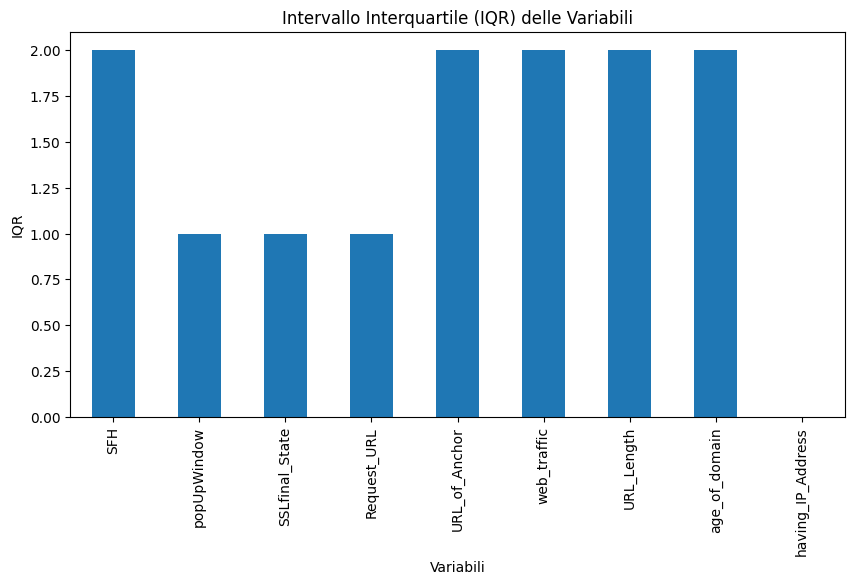

In [6]:
descrizione = data.describe()
display(descrizione)

# Calcolare il primo quartile (Q1) per ogni colonna
Q1 = data.quantile(0.25)

# Calcolare il terzo quartile (Q3) per ogni colonna
Q3 = data.quantile(0.75)

# Calcolare l'IQR per ogni colonna
IQR = Q3 - Q1

# Imposta le dimensioni del grafico
plt.figure(figsize=(10, 5))

# Crea un grafico a barre dell'IQR
IQR.plot(kind='bar')

# Aggiungi titolo e etichette agli assi
plt.title('Intervallo Interquartile (IQR) delle Variabili')
plt.xlabel('Variabili')
plt.ylabel('IQR')

# Mostra il grafico
plt.show()

## Model Training
Per il training del modello abbiamo deciso di utilizzare i decision trees con un alpha di 0.001. Abbiamo deciso di utilizzare questo valore perché se avessimo scelto un valore più grande il modello avrebbe creato overfitting, mentre un valore più piccolo avrebbe creato un albero di decisione troppo piccolo, quindi si sarebbe verificata una mancanza di informazioni.
Per la validazione del modello abbiamo usato l'**holdout validation**. Questo metodo è strutturato come segue:

- I dati vengono suddivisisi in due insiemi: training e testing.
- I dati di training Servono per addestrare il modello, i dati di testing per verificare quanto il modello sia in 
      grado di predirre dati che non ha mai visto.
            


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.8, random_state=42) 
"""
random_state ensures that the splits that you generate are reproducible. 
Scikit-learn uses random permutations to generate the splits. 
The random state that you provide is used as a seed to the random number generator.
This ensures that the random numbers are generated in the same order.

With this variable, test and training variables are always split in the same way, even if data changes.
"""

tree_model = DecisionTreeClassifier(criterion = 'gini', ccp_alpha=0.001)
tree_model.fit(X_train, y_train)

y_predicted_train = tree_model.predict(X_train)
y_predicted_test = tree_model.predict(X_test)

training_acc = accuracy_score(y_train, y_predicted_train)
testing_acc = accuracy_score(y_test, y_predicted_test)

print(f'Training accuracy: {training_acc}.\nTesting accuracy: {testing_acc}.')

Training accuracy: 0.9417744916820703.
Testing accuracy: 0.9003690036900369.


In [ ]:

# Estraggo dal dataset i nomi delle Features e li inserisco in una lista
nomi_variabili = website_phishing.variables.name
features = list(nomi_variabili)

# Rappresentazione grafica del Decision Tree
fig, ax = plt.subplots(figsize=(40, 20))  
plot_tree(tree_model, ax=ax, fontsize=10, \
          feature_names = features, filled=True)
plt.show()

## Risultati
In questa porzione di codice mostriamo i risultati ottenuti dall'addestramento.
In base al tipo di sito nel DataSet sono stati assegnati i seguenti valori:
- Siti phishing = -1.
- Siti no_phishing = 1.
- Siti suspicious = 0.

I siti sono indicati con dei numeri, partendo da quelli testati li indicizziamo nella suddetta matrice.

In [ ]:
siti_test = y_test.index
# Dataframe Per Visualizzazione
results_df = pd.DataFrame({'Valore Reale': y_test['Result'], 'Valore Predetto': y_predicted_test}, index=siti_test)

print(results_df)
# Mappa i valori 1, -1 e 0 alle etichette desiderate
results_df['Valore Reale'] = results_df['Valore Reale'].replace({-1: 'phishing', 1: 'non phishing', 0: 'suspicious'})
results_df['Valore Predetto'] = results_df['Valore Predetto'].replace({-1: 'phishing', 1: 'non phishing', 0: 'suspicious'})

# Salva il DataFrame aggiornato in un nuovo file Excel
results_df.to_excel('ValoriVeri_Predetti_Etichette.xlsx', index=True)

print("Valori correttamente predetti:")
display(results_df[results_df['Valore Reale'] == results_df['Valore Predetto']])

print("\nValori erroneamente predetti:")
display(results_df[results_df['Valore Reale'] != results_df['Valore Predetto']])

print(X_test)

In [ ]:
phishing = 0
no_phishing = 0
suspicious = 0
predetto_male = 0
array = np.array(y_test)
array2 = np.array(list(y_predicted_test))
for i in range(len(array)):
    if array[i] == -1 and array2[i] == -1:
        phishing += 1
    elif array[i] == 1 and array2[i] == 1:
        no_phishing += 1
    elif array[i] == 0 and array2[i] == 0:
        suspicious += 1
    else:
        predetto_male += 1

print("Totale siti phishing correttamente predetti:" ,phishing)

print("Totale siti non phishing correttamente predetti:" ,no_phishing)

print("Totale siti suspicious correttamente predetti:" ,suspicious)

print("Totale predetti correttamente:", phishing + suspicious + no_phishing)

print("Totale predetti erroneamente:", predetto_male)